In [2]:
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU 리스트:", tf.config.list_physical_devices('GPU'))

print("CUDA로 빌드됨?", tf.test.is_built_with_cuda())
print("GPU 사용 가능?", tf.test.is_gpu_available())



TensorFlow: 2.10.1
GPU 리스트: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA로 빌드됨? True
GPU 사용 가능? True


In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [2]:
# Keras 라이브러리 내 CIFAR-10 데이터셋 활용.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


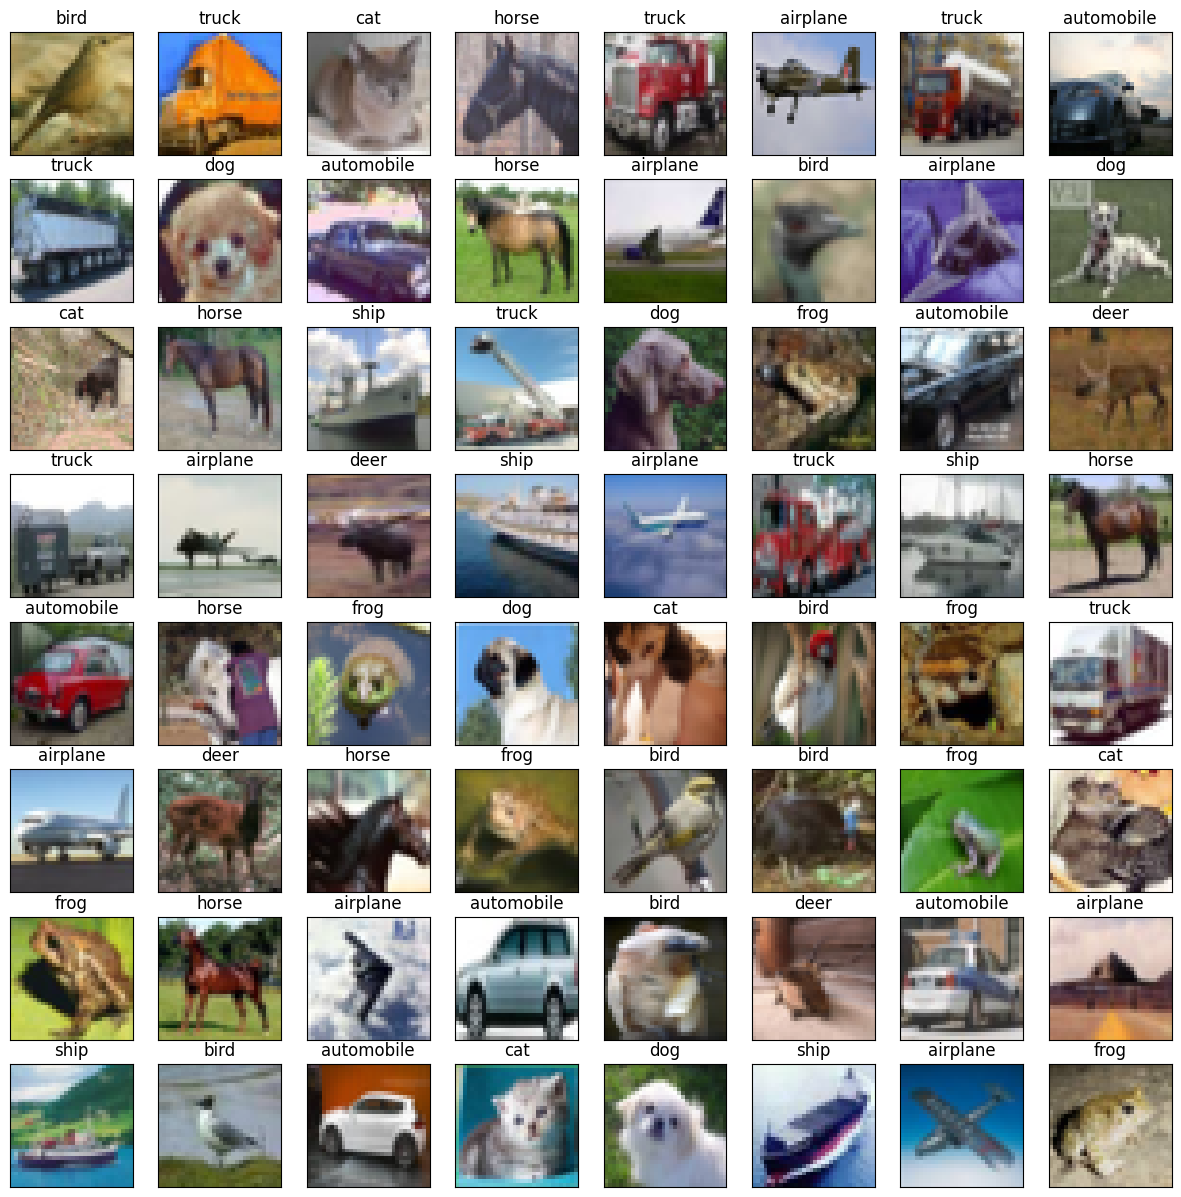

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               

plt.figure(figsize=(15,15))

# 첫 25 이미지 보기
for i in range(64):
    
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_train[i])

    plt.title(class_names[y_train[i][0]], fontsize=12)

plt.show()

In [6]:
# 픽셀 값을 실수값으로 변환
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# 정규화를 하기 위해 학습 데이터의 평균과 분산 구하기
mean = np.mean(X_train)
std  = np.std(X_train)

# 데이터 정규화하기
# 0으로 나눠지는 것 (=무한대로 수렴)을 막기 위해 1e-7 더기기
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [7]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [8]:
# 데이터 증강
data_generator = ImageDataGenerator(
    # 데이터 15도 돌리기 
    rotation_range=15,
    
    # 12% 정도로 옆 길이 늘리기
    width_shift_range=0.12,
    
    # 12% 정도로 위아래 길이 늘리기ㅣ
    height_shift_range=0.12,
    
    # 반전 시키기
    horizontal_flip=True,
    
    # 10% 확대시키기
    zoom_range=0.1,
    
    # 밝기를 높히고 줄이기
    brightness_range=[0.9,1.1],

    # 10도 정도 끝부분 깎기
    shear_range=10,
    
    # 색상 RGB 바꾸기
    channel_shift_range=0.1,
)

In [9]:
# 모델 초기화
model = Sequential()

# L2 정규화
weight_decay = 0.0001

# 첫번재 conv2D 3x3 크기의 32개의 filters
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# batch norm 추가
model.add(BatchNormalization())

# 두번째 conv2D
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# 2x2크기의 첫번째 maxpooling 층
model.add(MaxPooling2D(pool_size=(2, 2)))
# 0.2 dropout 층 추가
model.add(Dropout(rate=0.2))

# 64filters 세번째 네번째 층 추가
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# 두번째 maxpooling 추가 및 0.3으로 중가
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# 128 filters의 다섯번째 여섯번째 층 추가
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# 세번째 maxpooling 추가 및 0.4로 증가
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# 256 filters의 일곱번째 여덟번째 층 추가
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# 네번째 maxpooling 추가 및 0.5로 증가
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# 이전 층의 아웃풋 텐서를 flatten
model.add(Flatten())

# 10개 레이블에 대한 softmax 층 출력
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
# 학습 배치 사이즈 설정
batch_size = 64

# 학습 에포크 수 설정
epochs = 300

# optimizer 설정 (Adam)
optimizer = Adam(learning_rate=0.0005)

# 모델 loss랑 metrics compile 하기
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ReduceLROnPlateau 콜백 추가
# 검증 손실(val_loss)이 5 epoch 동안 개선되지 않으면 학습률을 절반(factor=0.5)으로 줄입니다.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# 얼리 스토핑(EarlyStopping) 설정
# 검증 손실(val_loss)이 5 epoch 동안 향상되지 않으면 자동으로 학습을 중지합니다.
# `restore_best_weights` 매개변수는 모니터링하는 지표(여기서는 'val_loss')가
# 가장 좋았던 epoch의 가중치로 모델 가중치를 되돌려 줍니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 학습 데이터에 대해 정의된 배치 크기와 epoch 수로 모델을 학습합니다.
# 검증 데이터는 학습 과정에서 모델의 성능을 평가하는 데 사용됩니다.
# 사용된 콜백은 검증 손실이 개선되지 않아 plateau 상태가 되면 학습률을 감소시키고,
# 일정 기간 동안 향상이 없으면 학습을 조기에 종료합니다.
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

Epoch 1/300
704/704 - 601s - loss: 2.3758 - accuracy: 0.3315 - val_loss: 1.7665 - val_accuracy: 0.4552 - lr: 5.0000e-04 - 601s/epoch - 854ms/step
Epoch 2/300
704/704 - 21s - loss: 1.7369 - accuracy: 0.4609 - val_loss: 1.4810 - val_accuracy: 0.5352 - lr: 5.0000e-04 - 21s/epoch - 30ms/step
Epoch 3/300
704/704 - 22s - loss: 1.5075 - accuracy: 0.5308 - val_loss: 1.2861 - val_accuracy: 0.5976 - lr: 5.0000e-04 - 22s/epoch - 31ms/step
Epoch 4/300
704/704 - 22s - loss: 1.3420 - accuracy: 0.5793 - val_loss: 1.1425 - val_accuracy: 0.6356 - lr: 5.0000e-04 - 22s/epoch - 31ms/step
Epoch 5/300
704/704 - 34s - loss: 1.2084 - accuracy: 0.6223 - val_loss: 1.0904 - val_accuracy: 0.6664 - lr: 5.0000e-04 - 34s/epoch - 48ms/step
Epoch 6/300
704/704 - 73s - loss: 1.1068 - accuracy: 0.6536 - val_loss: 0.9282 - val_accuracy: 0.7152 - lr: 5.0000e-04 - 73s/epoch - 104ms/step
Epoch 7/300
704/704 - 75s - loss: 1.0402 - accuracy: 0.6749 - val_loss: 0.8948 - val_accuracy: 0.7312 - lr: 5.0000e-04 - 75s/epoch - 107ms

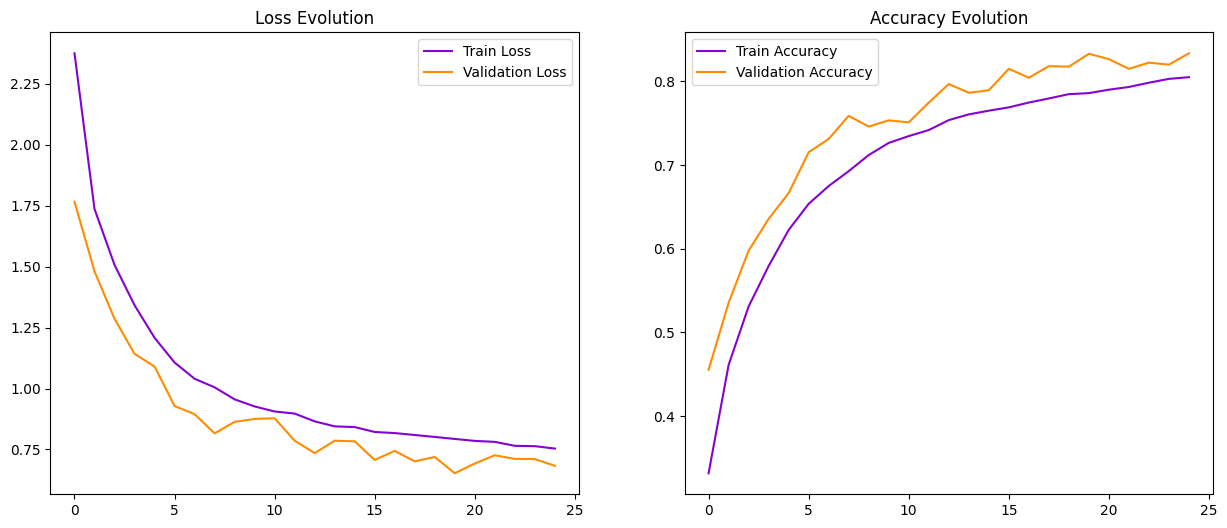

In [12]:
plt.figure(figsize=(15,6))

# loss 그래프
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [13]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 1s 3ms/step - loss: 0.6530 - accuracy: 0.8366

Test Accuracy: 0.8366000056266785
Test Loss:     0.6529731154441833


In [14]:
# 깃허브에서 예시 이미지 가져오기
url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# 이미지 전처리 "BGR to RGB" - 중요하지 않음
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

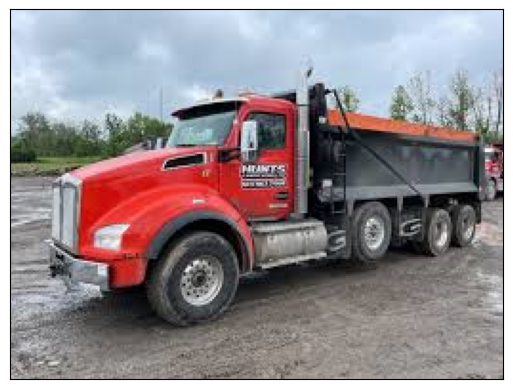

In [15]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [16]:
# 32x32 pixels 크기로 리사이즈
image = cv2.resize(image, (32,32))

# 이미지 정규화
image = (image-mean)/(std+1e-7)

# 차원 조정.
image = image.reshape((1, 32, 32, 3))

In [17]:
prediction = model.predict(image)

1/1 [==============================] - 0s 247ms/step


In [18]:
# 이미지 레이블만 가져오기
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  truck
